In [1]:
import matplotlib.pyplot as plt
import numpy as np
from amuse.units import units
import matplotlib.ticker

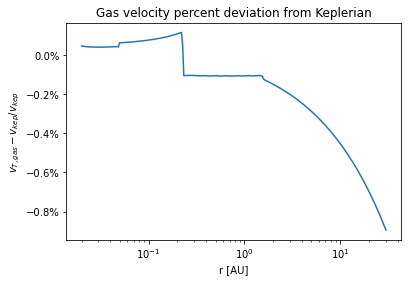

In [2]:
r, vt_gas_cms = np.loadtxt("mdot9disk20220601/vt_gas.txt").T
vt_gas = (vt_gas_cms | units.cm / units.s).value_in(units.au / units.yr)
keplerian = (r ** (-1.0/2) * 2 * np.pi)

fig, ax = plt.subplots()
ax.plot(r, 100*(vt_gas - keplerian)/keplerian)

ax.set_xscale("log")
ax.set_xlabel("r [AU]")

ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=1))
ax.set_ylabel("$v_{T,gas}-v_{kep} / v_{kep}$")
ax.set_title("Gas velocity percent deviation from Keplerian")

plt.savefig("vt_gas_keplerian_deviation.png", facecolor="white")
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Create velocity.txt and density.txt for the data from Xiao

# r = np.linspace(0.05, 0.50, 1000)
r = np.loadtxt("mdot9disk20220601/rad_chart.txt")

def load_data(name):
    _r, _l = np.loadtxt(f"mdot9disk20220601/{name}.txt").T
    # return interp1d(_r, _l, kind="quadratic")(r)
    return _l

# Merge velocity files
vt_gas = load_data("vt_gas")
vr_gas = load_data("vr_gas")

velocity = np.column_stack([r, vt_gas, vr_gas])
# np.savetxt("velocity.txt", velocity, fmt="%.6e")

# Calculate density
T = load_data("temperature")
k_B = 1.3807e-16 # cm^2 g s^-2 K^-1
m_p = 1.66e-24; mu = 2.33; gamma = 1.4
c_s = np.sqrt(gamma * k_B * T / (mu * m_p)) # cm s^-1

r_cm = r * 14959787069100
Ω = 2 * np.pi * (r ** (-3.0 / 2)) / (31558150) # s^-1
H = c_s / Ω
v_K = r_cm * Ω
# np.savetxt("scale_height_2.txt", np.column_stack([r, H]), fmt="%.6e")

rho_p = 3
v = v_K - vt_gas
va = np.abs(v)
vs = np.sign(v)

sigma = load_data("sigma")
rho_0 = sigma / (H * np.sqrt(2*np.pi))
# np.savetxt("midplane_density_2.txt", np.column_stack([r, rho_0]), fmt="%.6e")

alpha = load_data("alpha")

nd = sigma / (2 * H * m_p * mu)
la = 1 / (nd * 2e-15)
nu = la * c_s
eta = nu * rho_0

l = np.logical_and(r > 0.15, r < 0.35)
Re_a = 2 * va * rho_0 / eta

lM = np.linspace(-3, 0, 100)
M = np.power(10., lM)
a = (M * 5.97e27 * 3 / (rho_p * 4 * np.pi))**(1. / 3)
Re = Re_a[:, np.newaxis] * a[np.newaxis, :]

# t_fric = np.zeros_like(Re)
# n = Re > 1.
# t_fric[n] = ((2**(.6) * rho_p * a[np.newaxis, :]**1.6) / (9 * (eta**.6 * rho_0**.4 * va**.4)[:, np.newaxis]))[n]
# n = np.logical_not(n)
# t_fric[n] = ((2 * rho_p * a[np.newaxis, :]**2.) / (9 * (eta)[:, np.newaxis]))[n]
# n = Re > 800.
# t_fric[n] = (6 * rho_p * a[np.newaxis, :] / (rho_0 * va)[:, np.newaxis])[n]

# t_fric = ((2 * rho_p * a[np.newaxis, :]**2.) / (9 * (eta)[:, np.newaxis]))

C_D = 1.0
F_D = -0.5 * C_D * np.pi * (a**2.)[np.newaxis, :] * (rho_0 * va**2. * vs)[:, np.newaxis]
a_D = F_D / (M * 5.97e27)[np.newaxis, :]
t_fric = -(M * 5.97e27)[np.newaxis, :] * v[:, np.newaxis] / F_D

tau = t_fric * Ω[:, np.newaxis]

_eta = 1 - np.square(vt_gas / v_K)
v_rp = (-_eta * v_K)[:, np.newaxis] / (tau + 1. / tau)

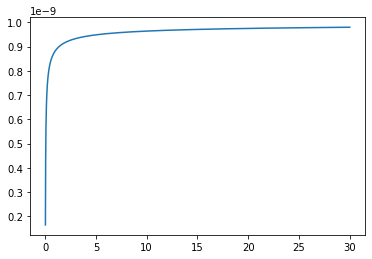

In [4]:
plt.plot(r, sigma * 3 * np.pi * alpha * c_s * H * 5.02785e-34 * 31558150)

In [5]:
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)

def g(value, _):
    if value == 0.0:
        return "0"

    e = np.floor(np.log10(np.abs(value)))
    s = np.round(value / 10**e, 10)
    exponent = "%d" % e
    significand = ("%d" if s % 1 == 0 else "%1.02f") % s
    exponent = "10^{%s}" % exponent
    return (f"${exponent}$" if s == 1 else f"${significand} \\times {exponent}$")

tickformat = mticker.FuncFormatter(g)

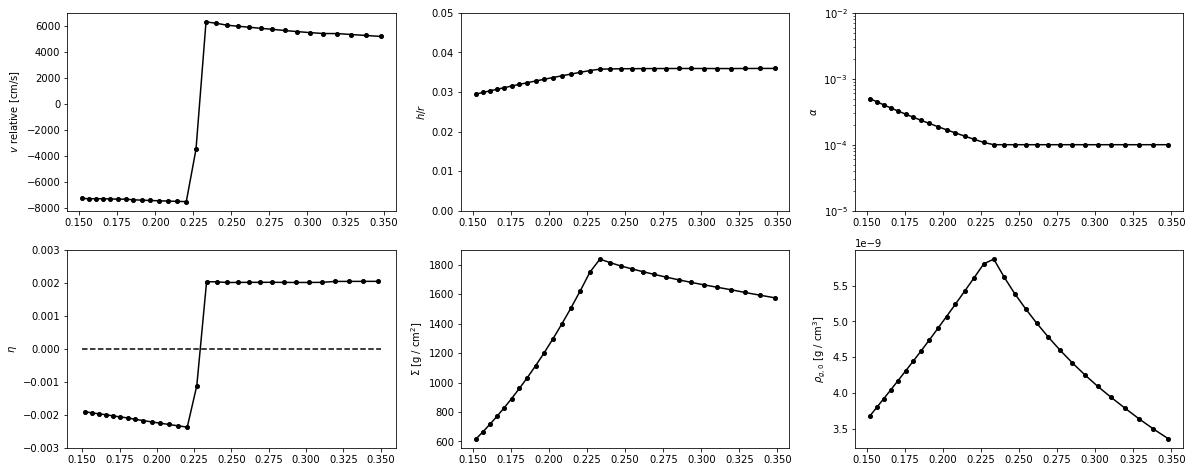

In [6]:
from matplotlib.rcsetup import cycler

plt.rc('axes', prop_cycle=(cycler(marker=['o'], ms=[4])))

fig, _axs = plt.subplots(2, 3, figsize=(20, 8))
axs = np.ravel(_axs)

axs[0].plot(r[l], v[l])
axs[0].set_ylabel("$v$ relative [cm/s]")

axs[1].plot(r[l], (H/r_cm)[l])
axs[1].set_ylim(0, 0.05)
axs[1].set_ylabel("$h/r$")

axs[2].plot(r[l], alpha[l])
axs[2].set_yscale("log")
axs[2].set_ylim(1e-5, 1e-2)
axs[2].set_ylabel("$\\alpha$")

axs[4].plot(r[l], sigma[l])
axs[4].set_ylabel("$\\Sigma$ [g / cm$^2$]")

axs[5].plot(r[l], rho_0[l])
axs[5].set_ylabel("$\\rho_{g,0}$ [g / cm$^3$]")

axs[3].hlines(0, 0.15, 0.35, linestyles="--", color="black")
axs[3].plot(r[l], _eta[l])
axs[3].set_ylim(-0.003, 0.003)
axs[3].set_ylabel("$\\eta$")
# axs[3].yaxis.set_major_formatter(tickformat)

plt.savefig("disk.png")

In [7]:
k = np.logical_and(l[:, np.newaxis], v_rp < 0.)
j = np.logical_not(k)

def contourf_blocked(x, **kwargs):
    x_k = x.copy()
    x_k[j] = np.nan
    x_j = x.copy()
    x_j[k] = np.nan

    plt.contourf(r[l], lM, x_j[l].T, **kwargs)
    plt.contourf(r[l], lM, x_k[l].T, **kwargs)

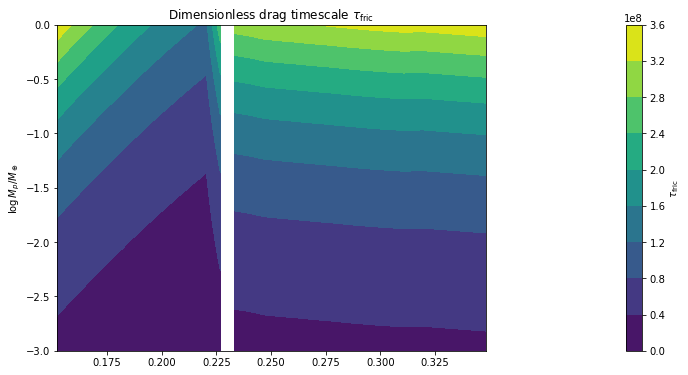

In [8]:
fig = plt.figure(figsize=(12, 6))
contourf_blocked(tau)
plt.ylabel("$\\log M_p / M_\oplus$")
plt.title("Dimensionless drag timescale $\\tau_{\\rm fric}$")
plt.colorbar(label="$\\tau_{\\rm fric}$")
b = plt.colorbar()
b.ax.set_visible(False)

plt.savefig("tau.png", bbox_extra_artists=b)

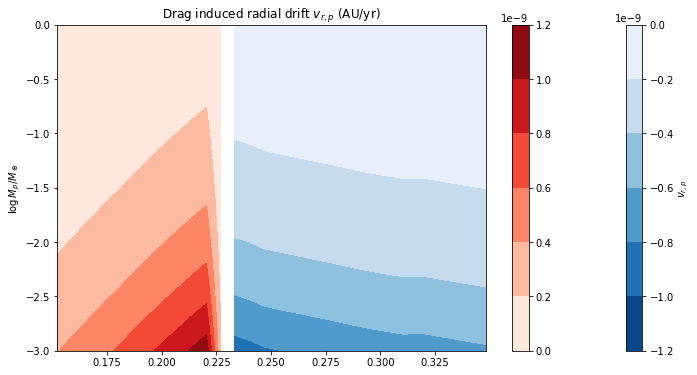

In [9]:
k = np.logical_and(l[:, np.newaxis], v_rp < 0.)
j = np.logical_not(k)

v_rp_k = v_rp.copy()
v_rp_k[k] = np.nan

v_rp_j = v_rp.copy()
v_rp_j[j] = np.nan

plt.figure(figsize=(12, 6))
a = plt.contourf(r[l], lM, (v_rp_k[l]).T * 2.109532e-6, np.arange(0, 12.1, 2)*1e-10, cmap="Reds")
b = plt.contourf(r[l], lM, (v_rp_j[l]).T * 2.109532e-6, -np.arange(0, 12.1, 2)[::-1]*1e-10, cmap="Blues_r")
plt.ylabel("$\\log M_p / M_\oplus$")
plt.title("Drag induced radial drift $v_{r,p}$ (AU/yr)")
plt.colorbar(b, label="$v_{r,p}$")
plt.colorbar(a, label="")
plt.savefig("v_r.png")

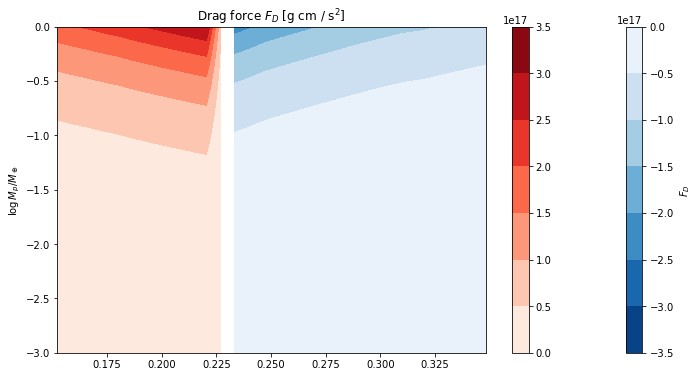

In [10]:

plt.figure(figsize=(12, 6))
a = plt.contourf(r[l], lM, np.ma.masked_where(k, F_D)[l].T, np.arange(0.0, 4e17, 0.5e17), cmap="Reds")
b = plt.contourf(r[l], lM, np.ma.masked_where(j, F_D)[l].T, np.arange(-3.5e17, 0.5e17, 0.5e17), cmap="Blues_r")
plt.ylabel("$\\log M_p / M_\oplus$")
plt.colorbar(b, label="$F_D$")
plt.colorbar(a)
plt.title("Drag force $F_D$ [g cm / s$^2$]")
plt.savefig("F_D.png")

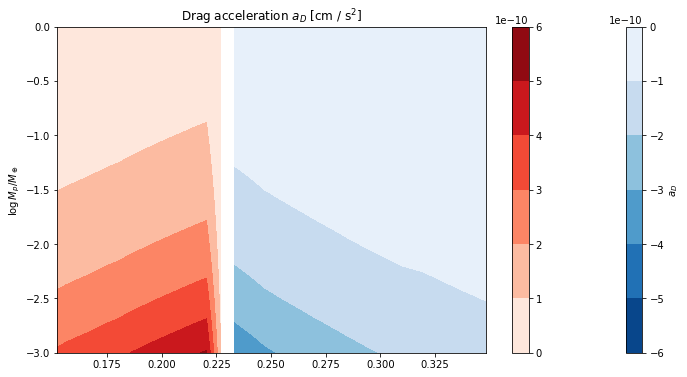

In [11]:
plt.figure(figsize=(12, 6))
a = plt.contourf(r[l], lM, np.ma.masked_where(k, a_D)[l].T, np.arange(0.0, 7e-10, 1.e-10), cmap="Reds")
b = plt.contourf(r[l], lM, np.ma.masked_where(j, a_D)[l].T, np.arange(-6e-10, 1e-10, 1.e-10), cmap="Blues_r")
plt.ylabel("$\\log M_p / M_\oplus$")
plt.colorbar(b, label="$a_D$")
plt.colorbar(a)
plt.title("Drag acceleration $a_D$ [cm / s$^2$]")
plt.savefig("a_D.png")

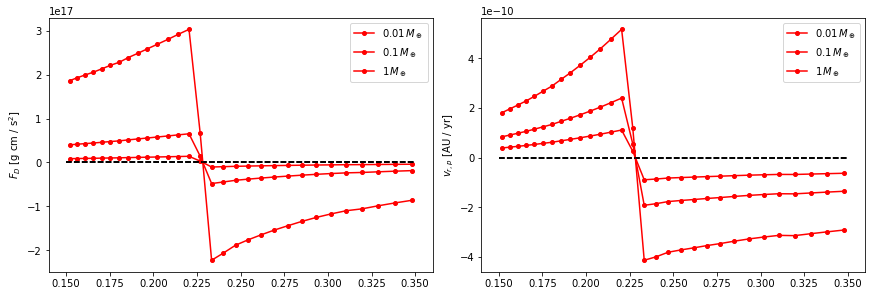

In [12]:
_i = [33, 66, 99]
n = ["0.01", "0.1", "1"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axs = np.ravel(axs)

plt.rc('axes', prop_cycle=(cycler(color=["r", "g", "b"]) * cycler(marker=['o'], ms=[4])))

for i, _n in zip(_i, n):
    axs[0].plot(r[l], F_D[l, i], label=f"${_n}\,M_\\oplus$")
    axs[0].hlines([0], 0.15, 0.35, linestyle="--", color="black")
    axs[0].legend()

    axs[1].plot(r[l], v_rp[l, i] * 2.109532e-6, label=f"${_n}\,M_\\oplus$")
    axs[1].hlines([0], 0.15, 0.35, linestyle="--", color="black")
    axs[1].legend()


axs[0].set_ylabel("$F_D$ [g cm / s$^2$]")
axs[1].set_ylabel("$v_{r,p} $ [AU / yr]")

plt.savefig("double.png")

In [13]:
low = 0.20
high = 0.26

x_i = np.linspace(0.15, 0.35, 10000)

sigma_i = interp1d(r, sigma, kind='cubic')(x_i)
rho_i = interp1d(r, rho_0, kind='cubic')(x_i)

(-10.0, 10.0)

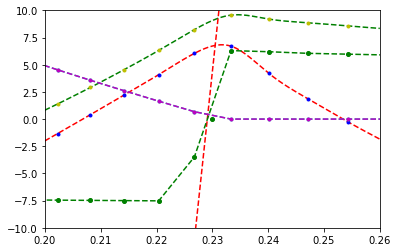

In [14]:
plt.plot(x_i, rho_i * 1e10 - 52, "--")
plt.plot(r, rho_0 * 1e10 - 52, "bo",  ms=3)

plt.plot(x_i, sigma_i * 0.015 - 18, "--")
plt.plot(r, sigma * 0.015 - 18, "yo",  ms=3)

plt.plot(r, _eta * 1e4, "r--o")
plt.plot(r, v * 1e-3, "g--o")

plt.plot(r, np.log10(alpha)*20 + 80, "c--o",  ms=3)
alpha_p = np.poly1d([-6.6333076, -4.3837696, -0.37942259][::-1])(np.log10(r))
alpha_p[r > 0.232] = -4
plt.plot(r, alpha_p*20 + 80, "m--o",  ms=3)

plt.plot(0.23, 0)

plt.xlim(low, high)
plt.ylim(-10, 10)

(-5.0, -2.0)

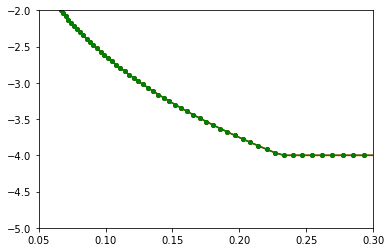

In [15]:
alpha_p = np.poly1d([-6.6333076, -4.3837696, -0.37942259][::-1])(np.log10(r))
alpha_p[r > 0.232] = -4
plt.plot(r, alpha_p)
plt.plot(r, np.log10(alpha))
plt.xlim(0.05, 0.30)
plt.ylim(-5, -2)

(0.2, 0.25)

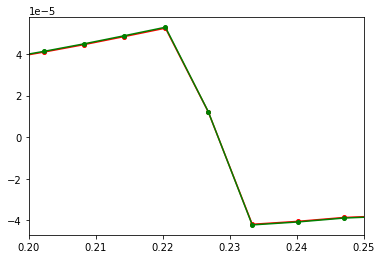

In [16]:
plt.plot(r[l], ((2 * F_D[:, 99] / 6e27) * np.sqrt((r_cm**3.) / (6.67e-8 * 2e33)))[l])
plt.plot(r[l], v_rp[l, 99], label=f"${_n}\,M_\\oplus$")
plt.xlim(0.2, 0.25)

In [17]:
r_cm

array([  2.99195741e+11,   3.07872418e+11,   3.16788451e+11,
         3.25973760e+11,   3.35413386e+11,   3.45137247e+11,
         3.55130385e+11,   3.65422719e+11,   3.76014248e+11,
         3.86919933e+11,   3.98124813e+11,   4.09658809e+11,
         4.21536880e+11,   4.33759026e+11,   4.46325247e+11,
         4.59250503e+11,   4.72564714e+11,   4.86252919e+11,
         5.00345038e+11,   5.14856032e+11,   5.29770939e+11,
         5.45119681e+11,   5.60917216e+11,   5.77178505e+11,
         5.93903547e+11,   6.11107302e+11,   6.28819690e+11,
         6.47040710e+11,   6.65800283e+11,   6.85083449e+11,
         7.04935086e+11,   7.25370155e+11,   7.46388656e+11,
         7.68020508e+11,   7.90280671e+11,   8.13184106e+11,
         8.36745770e+11,   8.60995585e+11,   8.85948510e+11,
         9.11619504e+11,   9.38038488e+11,   9.65220421e+11,
         9.93195223e+11,   1.02197785e+12,   1.05158327e+12,
         1.08205636e+12,   1.11342703e+12,   1.14568033e+12,
         1.17889106e+12,

In [34]:
print("\n".join(f"*xp++ = {xp:06e}; *vtp++ = {vt:06e} * CM_PER_S; *vrp++ = {vr:06e} * CM_PER_S; *dp++ = {dp:06e} * G_PER_CM3; n++;" for xp, vt, vr, dp in zip(r, vt_gas, vr_gas, rho_0)))

*xp++ = 2.000000e-02; *vtp++ = 2.107132e+07 * CM_PER_S; *vrp++ = 2.246802e+03 * CM_PER_S; *dp++ = 1.620334e-09 * G_PER_CM3; n++;
*xp++ = 2.058000e-02; *vtp++ = 2.077247e+07 * CM_PER_S; *vrp++ = 2.114639e+03 * CM_PER_S; *dp++ = 1.599020e-09 * G_PER_CM3; n++;
*xp++ = 2.117600e-02; *vtp++ = 2.047768e+07 * CM_PER_S; *vrp++ = 1.994472e+03 * CM_PER_S; *dp++ = 1.576198e-09 * G_PER_CM3; n++;
*xp++ = 2.179000e-02; *vtp++ = 2.018698e+07 * CM_PER_S; *vrp++ = 1.884303e+03 * CM_PER_S; *dp++ = 1.552227e-09 * G_PER_CM3; n++;
*xp++ = 2.242100e-02; *vtp++ = 1.990056e+07 * CM_PER_S; *vrp++ = 1.782587e+03 * CM_PER_S; *dp++ = 1.527690e-09 * G_PER_CM3; n++;
*xp++ = 2.307100e-02; *vtp++ = 1.961830e+07 * CM_PER_S; *vrp++ = 1.688110e+03 * CM_PER_S; *dp++ = 1.502769e-09 * G_PER_CM3; n++;
*xp++ = 2.373900e-02; *vtp++ = 1.933996e+07 * CM_PER_S; *vrp++ = 1.598422e+03 * CM_PER_S; *dp++ = 1.479943e-09 * G_PER_CM3; n++;
*xp++ = 2.442700e-02; *vtp++ = 1.906561e+07 * CM_PER_S; *vrp++ = 1.513216e+03 * CM_PER_S; *dp++ =